# Momentum Buildup Analysis
As part of the low perigee considerations, we are considering allowing larger momentum buildup. 

The following analysis is done using engineering archive data from 2016 to 2020

We used the MSID AORWSPD[1-6] that is the Reaction Wheel Estimated Speed. This value is blank when we are in safe mode. This value is in units of rad/s and is changed into units of rps and rpm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from kadi import events
from Ska.engarchive import fetch
from Ska.tdb import msids
import pandas as pd
import numexpr as ne
import math

t1998 = 883612730.816

## Gathering data
In this cell we are just pulling data from the Chandra engineering archive from 2015 to present changing the time values from Chandra time to python datetime.

In [2]:
#Looking at reaction wheel speed using AORWSPD1, AORWSPD2, AORWSPD3, AORWSPD4, AORWSPD5, AORWSPD6
#technical name "REACTION WHEEL ESTIMATED SPEED"
#they are units of rad/s, rpm = (rad/s)/2pi * 60
#fetch.data_source.set('maude')
#let's create a dict with the data we need and then we can iterate over that dict
msids = ['AORWSPD1', 'AORWSPD2' , 'AORWSPD3', 'AORWSPD4', 'AORWSPD5', 'AORWSPD6']
all_data = {}
for msid in msids:
    dat = fetch.Msid(msid, '2015:001:00:00:00')
    data_tme = dat.times
    times = np.array(pd.to_datetime(ne.evaluate('data_tme + t1998'), 
                                         unit = 's'), dtype = 'datetime64[s]')
    df = pd.DataFrame({'times': times, msid: dat.vals})
    all_data.update({msid: df})
print(all_data.keys)

<built-in method keys of dict object at 0x7f02188038b8>


### Processing data
In this cell we get rid of any outliers and convert from rad/s to rps and rpm as well as calculating total revolutions. 

We subtract the time entries in between rows to get "duration". If duration is longer than 20 seconds we assume that there was an error in data collection and drop that value. This only happened once in 2015. 
We print the first three rows of each data from for inspection. 

In [3]:
print(all_data.keys())
#get rid of any outliers, calculate rps, rpm, dur and total revolutions
for msid in all_data:
    df = pd.DataFrame()
    df = all_data[msid]
    df = df[(df[msid] > -550) & (df[msid] < 800)].reset_index(drop = True)
    df['rps'] = (df[msid]/(2*math.pi))
    df['rpm'] = df.rps*60
    #find the # of revolutions every hour or so
    df['dur'] = (df['times'].shift(-1) - df['times']).dt.total_seconds()
    df = df[df['dur']<20].reset_index(drop = True)
    df['total_rev'] = abs(df.rps)*df.dur
    print(df[:3]) 
    all_data.update({msid : df})

dict_keys(['AORWSPD1', 'AORWSPD2', 'AORWSPD3', 'AORWSPD4', 'AORWSPD5', 'AORWSPD6'])
                times    AORWSPD1        rps         rpm  dur   total_rev
0 2015-01-01 00:00:00  163.464966  26.016257  1560.97544  4.0  104.065029
1 2015-01-01 00:00:04  165.508270  26.341459  1580.48756  4.0  105.365837
2 2015-01-01 00:00:08  165.508270  26.341459  1580.48756  4.0  105.365837
                times    AORWSPD2        rps          rpm  dur   total_rev
0 2015-01-01 00:00:00 -279.933777 -44.552844 -2673.170659  4.0  178.211377
1 2015-01-01 00:00:04 -279.933777 -44.552844 -2673.170659  4.0  178.211377
2 2015-01-01 00:00:08 -279.933777 -44.552844 -2673.170659  4.0  178.211377
                times    AORWSPD3        rps          rpm  dur  total_rev
0 2015-01-01 00:00:00  147.118469  23.414632  1404.877896  4.0  93.658526
1 2015-01-01 00:00:04  147.118469  23.414632  1404.877896  4.0  93.658526
2 2015-01-01 00:00:08  145.075134  23.089425  1385.365484  4.0  92.357699
                times   

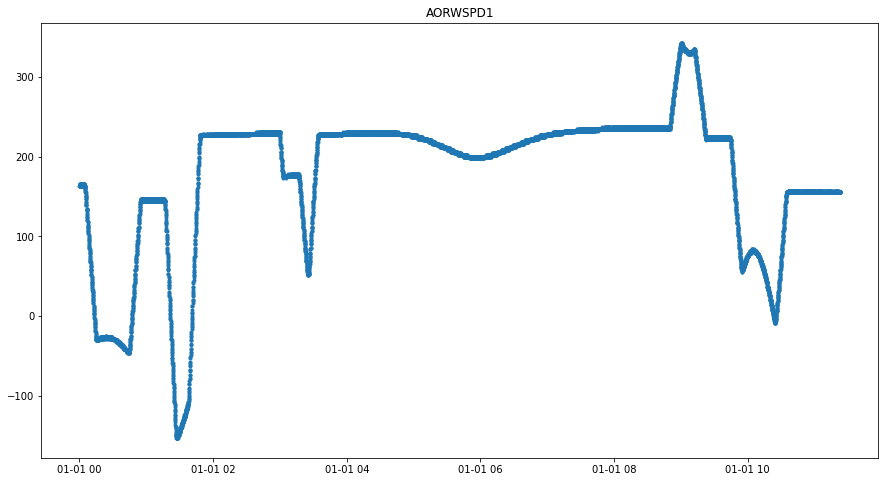

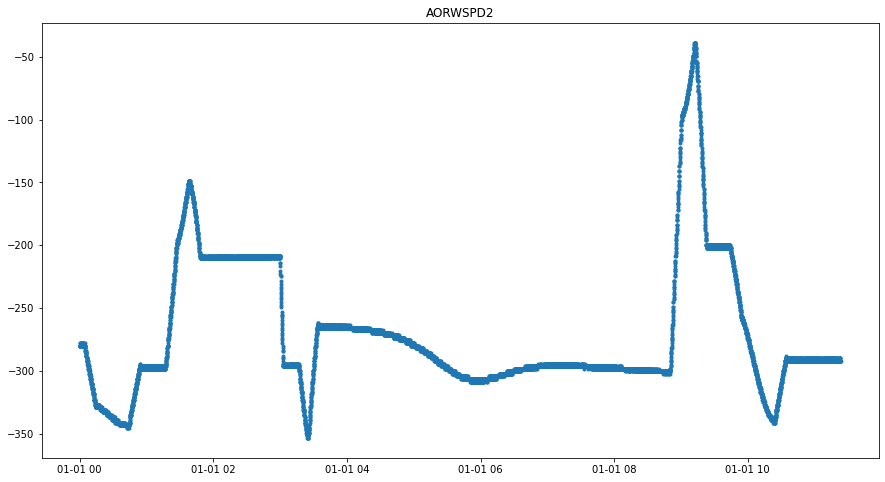

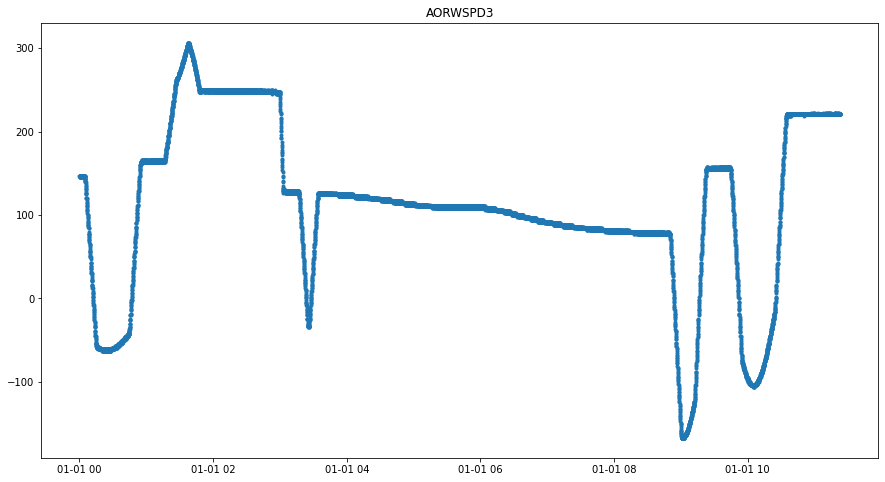

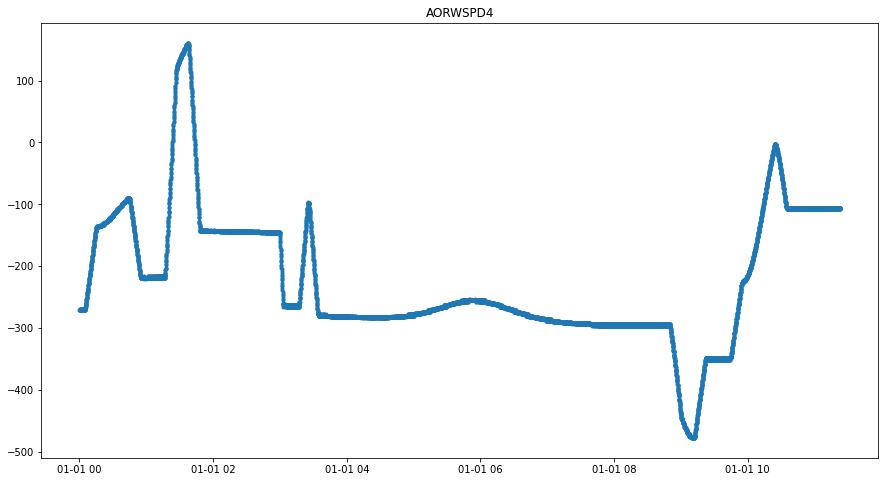

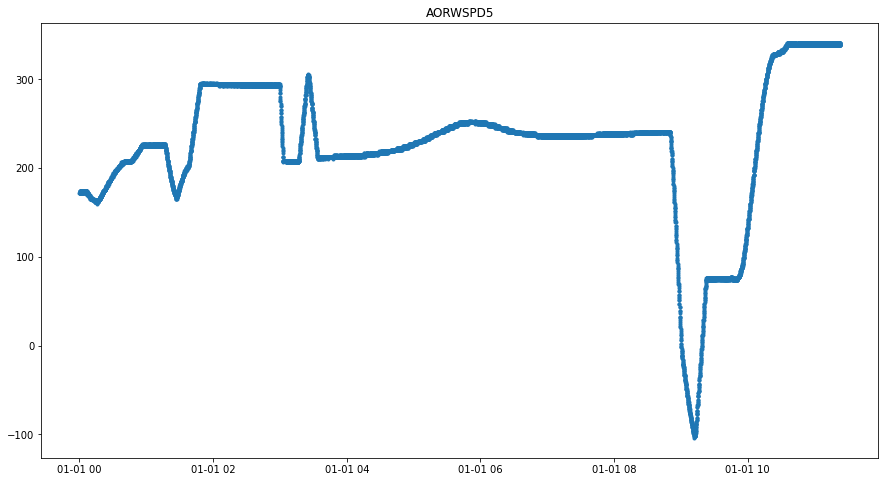

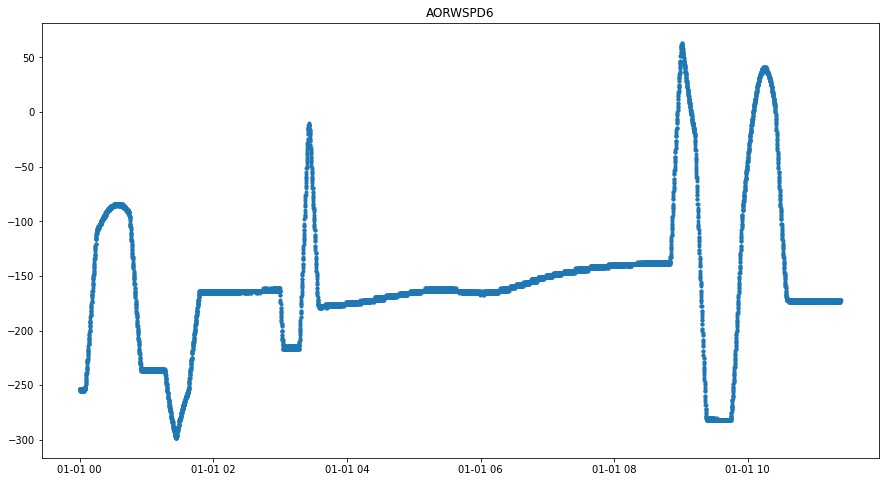

In [4]:
%matplotlib inline
for msid in all_data:
    df = pd.DataFrame(all_data[msid])
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot()
    ax.plot(df.times[:10000], df[msid][:10000], '.')
    ax.set_title('{}'.format(msid))


## Total number of revolutions for each wheel
We have already calculated the total number of revolutions per wheel based on the ~4 sec duration of each value in the telemetry. Here we resample the data to be once per hour and aggregate total revolutions as a sum. These values are plotter along with a histogram of the total density. 

For all wheels 120,000 total revolutions per hour is the average. 


dict_keys(['AORWSPD1', 'AORWSPD2', 'AORWSPD3', 'AORWSPD4', 'AORWSPD5', 'AORWSPD6'])


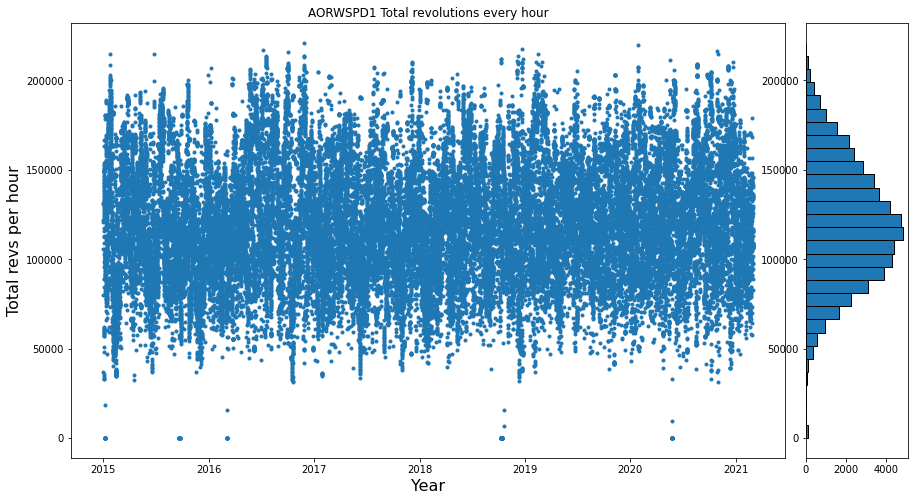

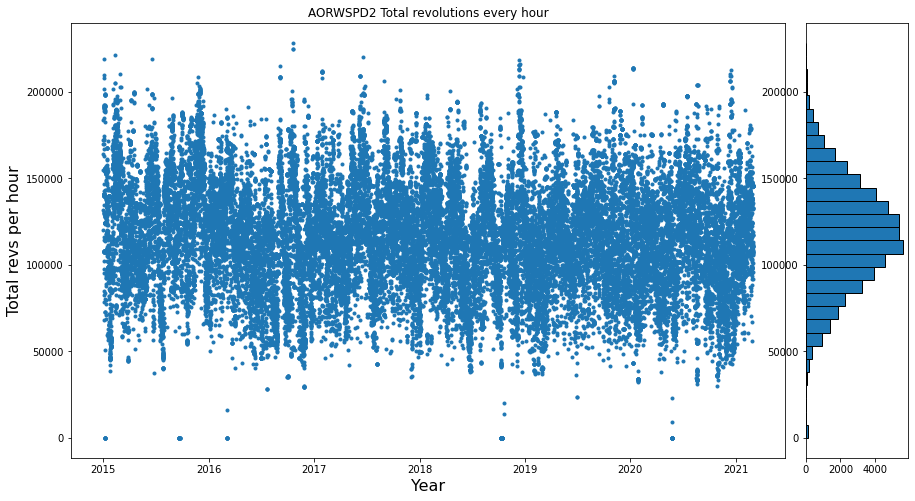

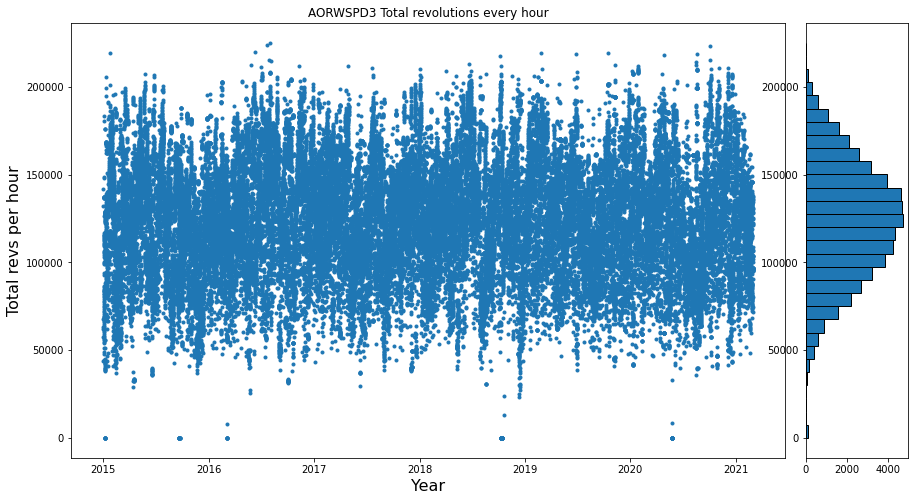

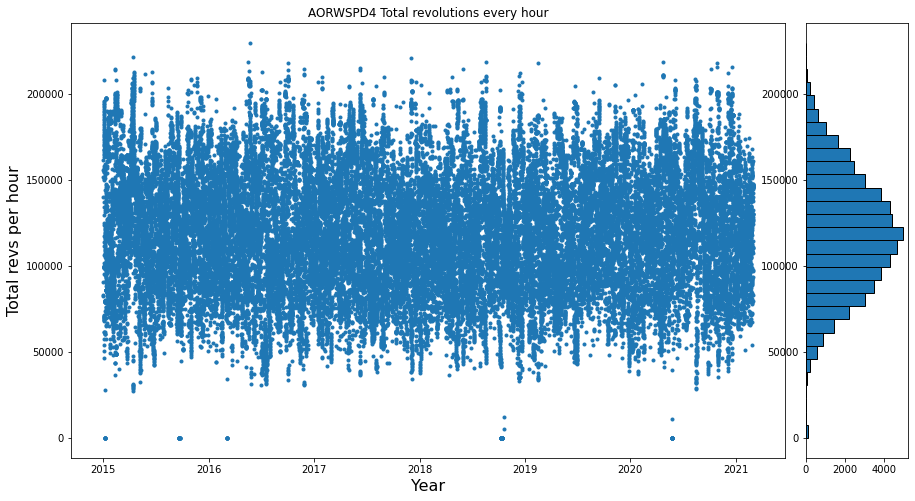

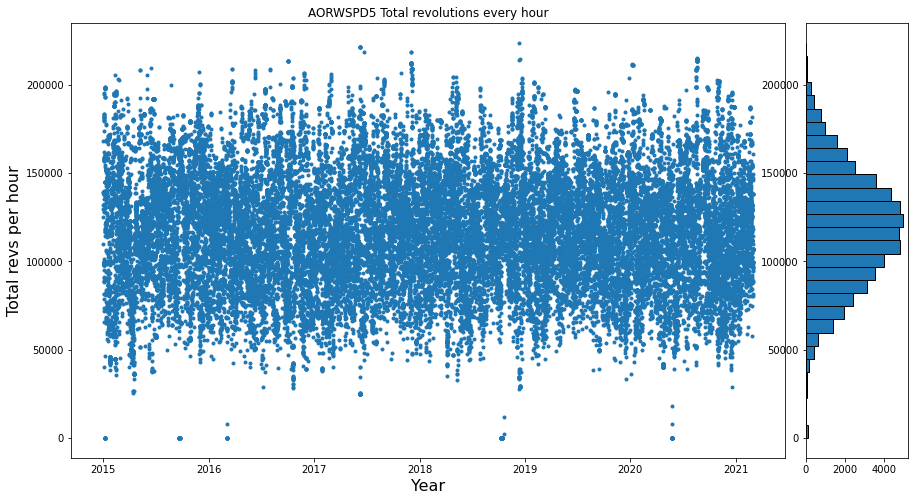

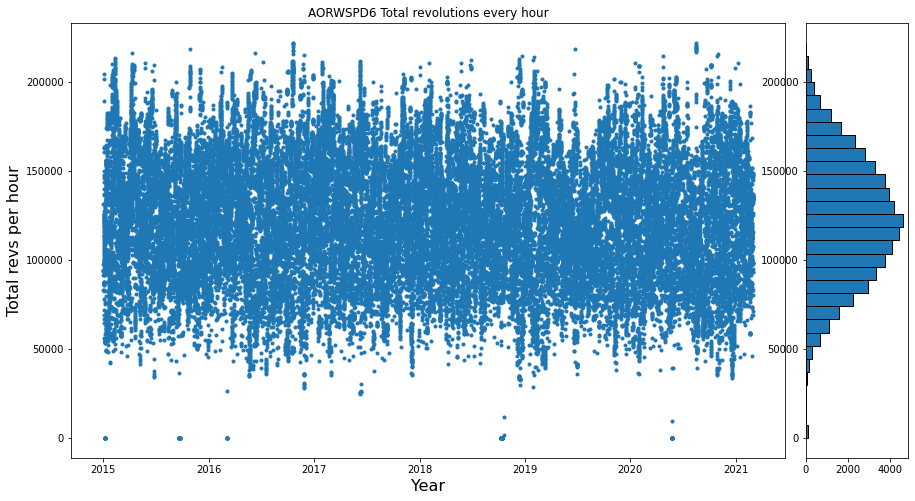

In [5]:
%matplotlib inline
#let's plot the total_revs every hour, does not account for 
print(all_data.keys())
for msid in all_data:
    df = pd.DataFrame(all_data[msid])
    df_hour = df.resample('H', on = 'times').agg({'total_rev': 'sum', msid:'mean', 'rpm':'mean', 'rps':'mean'})
    #plotting routines
    fig = plt.figure(figsize = (15, 8))
    gs = GridSpec(1, 7, figure = fig)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(gs[0,:-1])
    ax.plot(df_hour.index, df_hour.total_rev, '.') #index is the time
    ax_hist = fig.add_subplot(gs[0, -1:])
    ax_hist.hist(df_hour.total_rev, bins = 30, orientation = 'horizontal', edgecolor = 'black')
    ax.set_title("{} Total revolutions every hour".format(msid))
    ax.set_xlabel("Year", fontsize = 16)
    ax.set_ylabel("Total revs per hour", fontsize = 16)

## Calculating zero crossings and speed changes for each wheel
In order to calculate the speed changes we need to smooth the data to avoid repeated measurements due to signal noise. 
The following cell shows that a rolling average of 20 rows (1 minute) still captures the complexity of the data. 


Text(0, 0.5, 'AORWSPD1 rad/s')

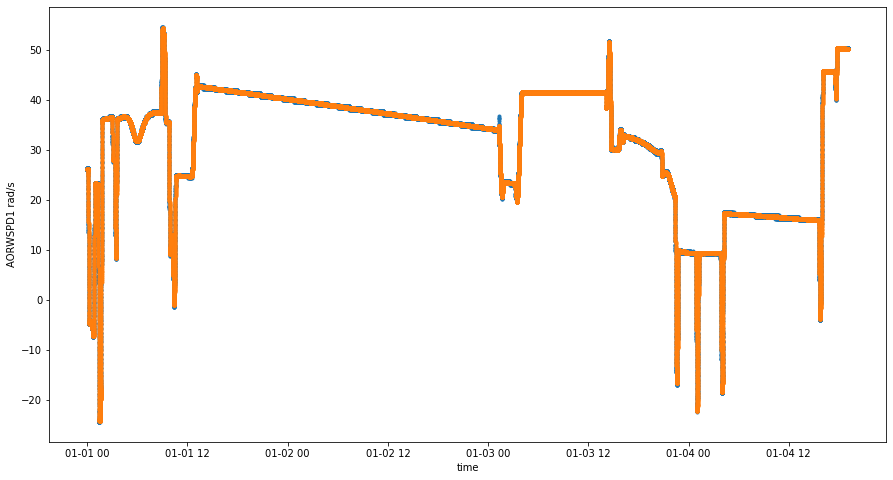

In [6]:
#total number of zero crossings - being defined as when the wheel speed changes from positive to negative thus "crossing zero"
#here we are just showing that wheel speed change is gradual and not abrupt
spd1 = all_data['AORWSPD1']
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot()
ax.plot(spd1['times'][0:80000], spd1['rps'][0:80000], '.')
ax.plot(spd1['times'][0:80000], spd1['rps'][0:80000].rolling(20).mean(), '.')
ax.set_xlabel('time')
ax.set_ylabel("AORWSPD1 rad/s")

## How we do our speed and zero crossings calculation
To calculate the zero crossings we look at the difference between subsequent values, if there is a change from negative to positive then we mark it down. Due to signal noise there is often some back and forth between numbers. For zero crossings we just use the groupby function to group together subsequent 1s and 0s and take the sum of that to identify zero crossings. 

Note, zero crossings are double counted, when you go from positive to negative and back to positive from negative.

To identify speed changes we smotth the data over 1 min and then take 5 min intervals of the data. If the speed changed greater then 100rpm in that time period we mark this down as a change. We group together these changes once more so that a steep incline with multiple speed changes will only be counted once. 

A test run of this is below:

Total zero crossings:   8
Total speed changes:  7


Text(0, 0.5, 'AORWSPD1 rad/s')

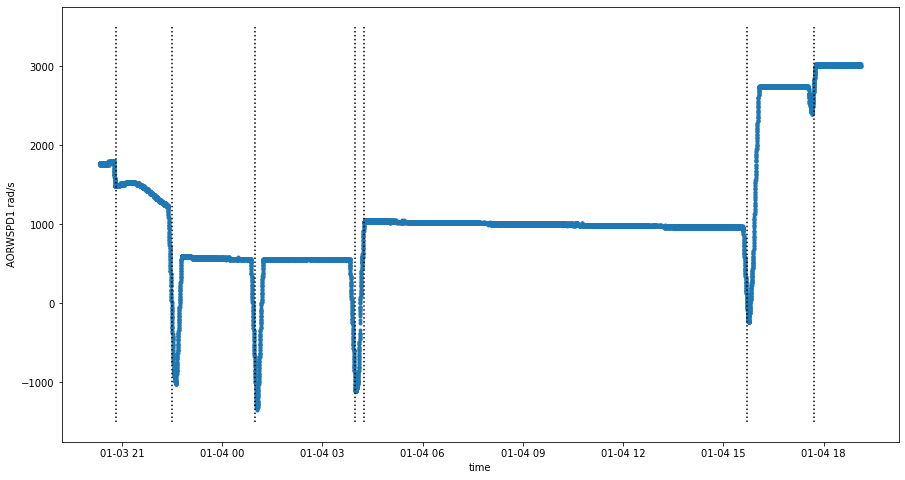

In [7]:
import itertools
spd1 = pd.DataFrame(all_data['AORWSPD1'][60000:80000])
#print(spd1.shape)
spd1['zero_cross'] = (spd1['AORWSPD1'] > 0).astype(int).diff().fillna(0).abs()
total_zero_crossings = np.array([int(i) for i, k in itertools.groupby(spd1['zero_cross'])]).sum()
print("Total zero crossings:  ", total_zero_crossings)

spd1['rpm_roll'] = spd1['rpm'].rolling(20, min_periods = 1).mean()
spd1_5min = spd1[::73].reset_index(drop = True)
spd1_5min['100rpm_change'] = ((spd1_5min['rpm_roll'].diff().abs())>100).astype(int)
spdc = np.array([i for i, k in itertools.groupby(spd1_5min['100rpm_change'])]).sum()
spdc_indexes = np.array([bool(i) for i, k in itertools.groupby(spd1_5min['100rpm_change'])])
cum_spdc = np.array([len(list(k)) for i, k in itertools.groupby(spd1_5min['100rpm_change'])])[spdc_indexes]

print("Total speed changes: ", spdc)

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot()
ax.plot(spd1['times'], spd1['rpm'], '.')
spdc_i = 0
counter = cum_spdc[0]
for index, row in spd1_5min.loc[spd1_5min['100rpm_change'] != 0].iterrows():
    if counter == cum_spdc[spdc_i]:
        ax.plot([row.times, row.times], [-1500,3500], 'k:')
        counter -=1
    else:
        counter -= 1
        if counter == 0 or counter <0:
            spdc_i +=1
            counter = cum_spdc[spdc_i]
        
ax.set_xlabel('time')
ax.set_ylabel("AORWSPD1 rad/s")

Here we have correctly identified 7 speed changes (marked by a dashed line) and 8 zero crossings. 

## Zero crossings
Zero crossings are aggregated by month using the method described above. 
These are the average zero crossings by wheel:
1. 98.05
2. 76.81
3. 97.59
4. 88.91
5. 59.70
6. 91.07

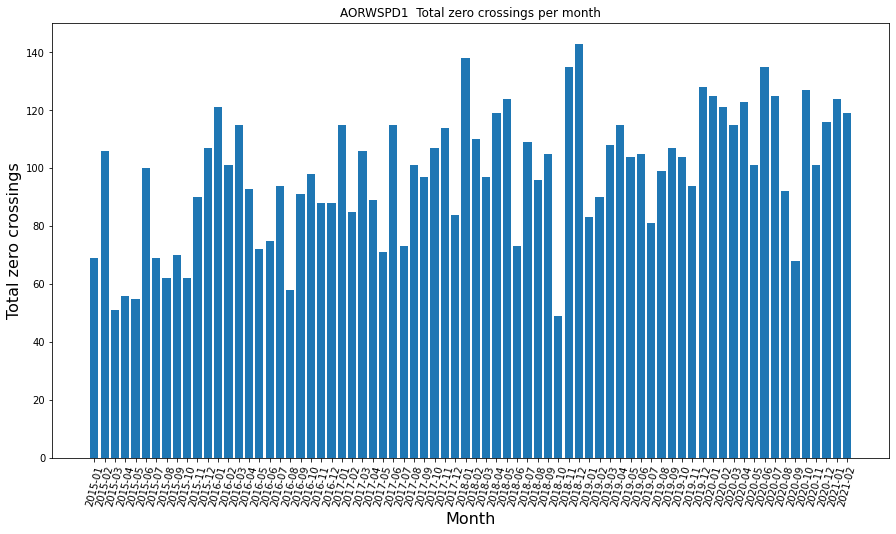

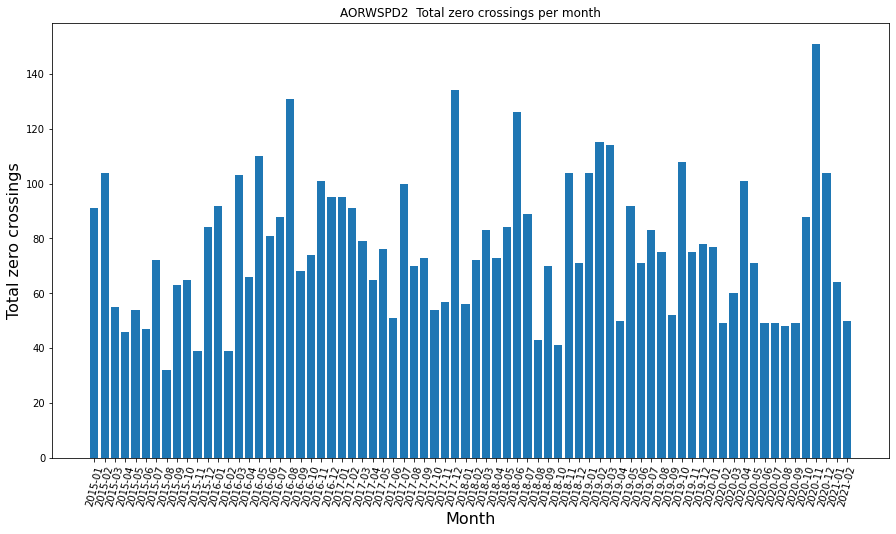

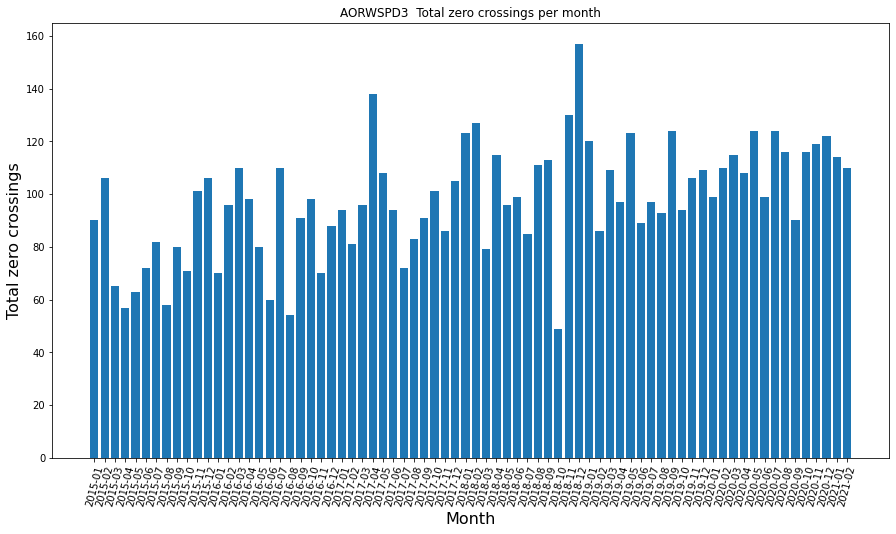

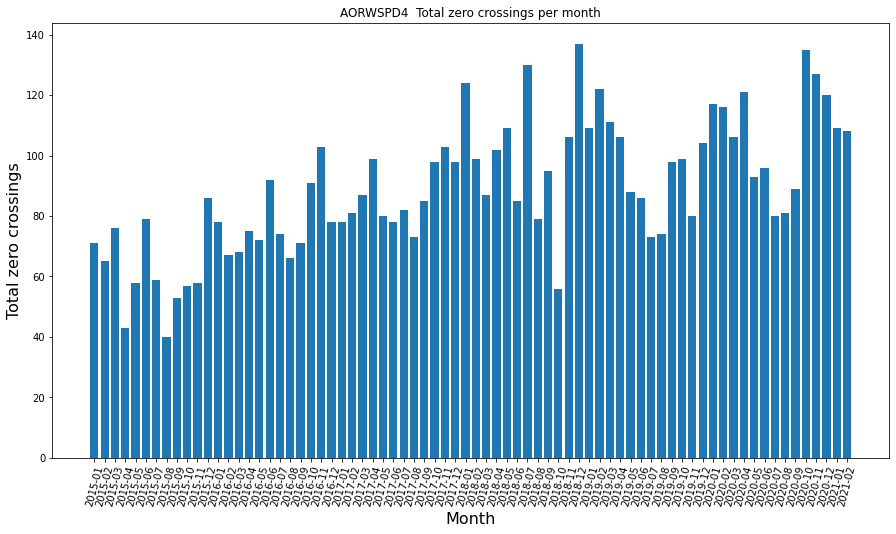

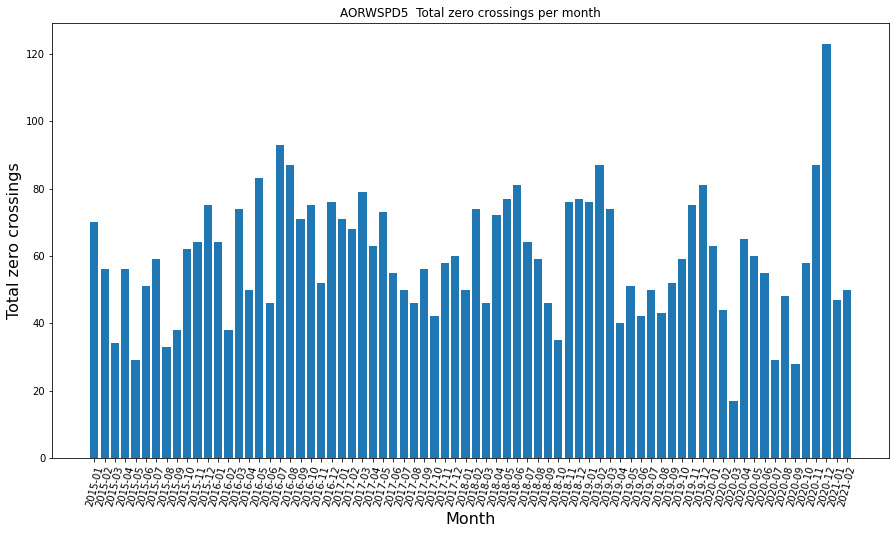

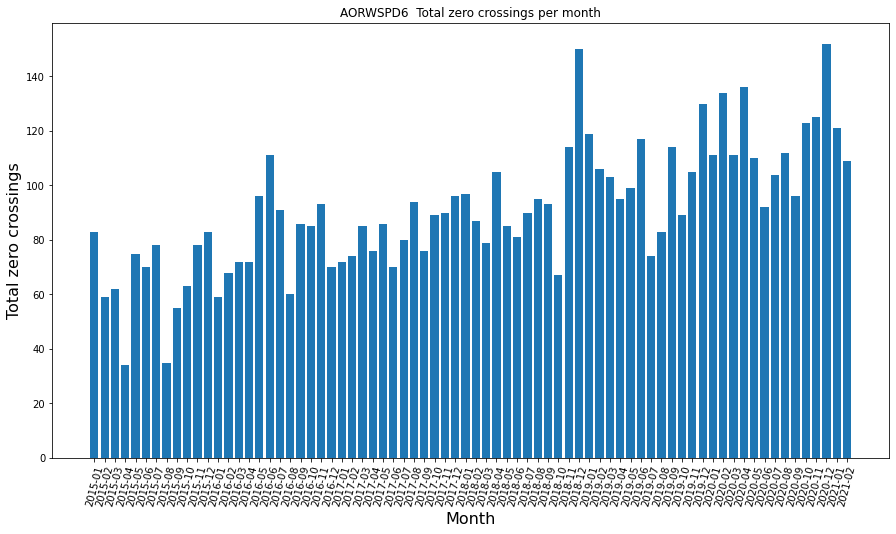

In [8]:
import itertools
for msid in all_data:
    df = pd.DataFrame()
    df = all_data[msid]
    #find zero crossings by comparing when a number has changed sign
    df['zero_cross'] = (df[msid] > 0).astype(int).diff().fillna(0).abs()
    #collapse zero crossings to deal with bouncy data
    #total_zero_crossings = [int(i) for i, k in itertools.groupby(spd1['zero_cross'])]
    start_date = pd.Timestamp(df['times'].iloc[0].date())
    end_date = pd.Timestamp(df['times'].iloc[-1].date())
    months = pd.interval_range(start = start_date, end = end_date, freq = 'MS')
    zero_crossings = []
    #spd1 = spd1.set_index('times')
    for interval in months:
        m_data = df[(df['times']>= interval.left) & (df['times']<= interval.right)]
        m_zc = np.array([int(i) for i, k in itertools.groupby(m_data['zero_cross'])]).sum()
        zero_crossings += [m_zc]
    fig = plt.figure(figsize = (15, 8))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot()
    plt_months = months.left.strftime('%Y-%m')
    ax.bar(plt_months, zero_crossings) #index is the time
    ax.set_title("{}  Total zero crossings per month".format(msid))
    ax.set_xlabel("Month", fontsize = 16)
    ax.set_ylabel("Total zero crossings", fontsize = 16)
    ax.tick_params('x', labelrotation = 75)

## Speed changes
A speed change is defined by a change of more than 100rpm in a 5 min period. It is calculated using the method described above. It is aggregated by month. 

The average # of speed chages by wheel is:
1. 207.91
2. 207.07
3. 208.66
4. 212.49
5. 208.38
6. 213.61

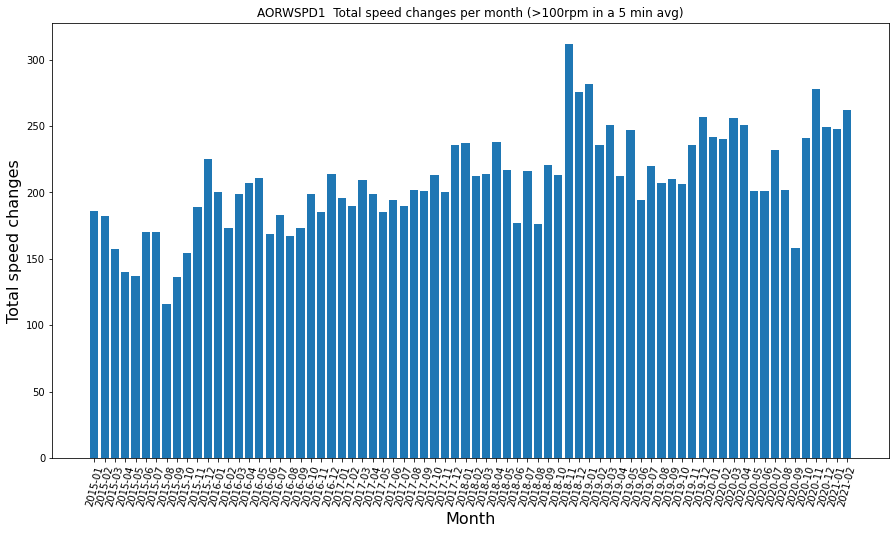

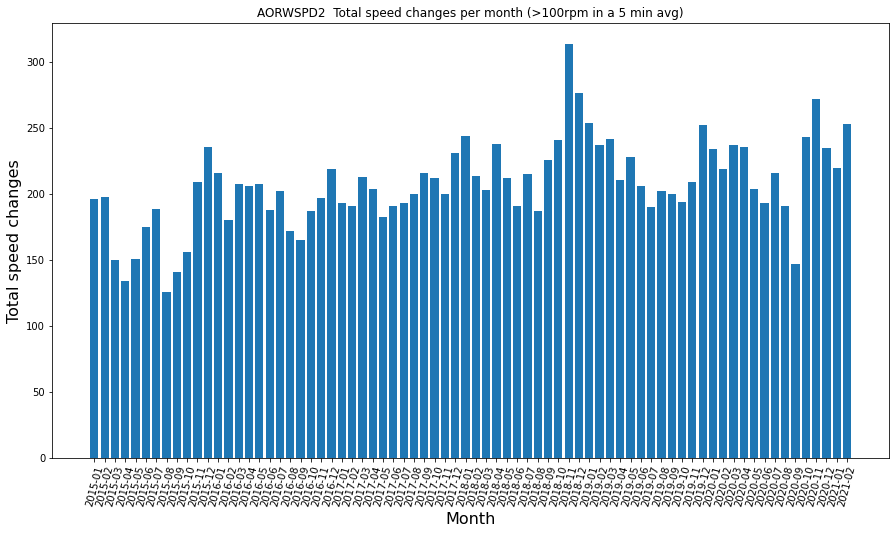

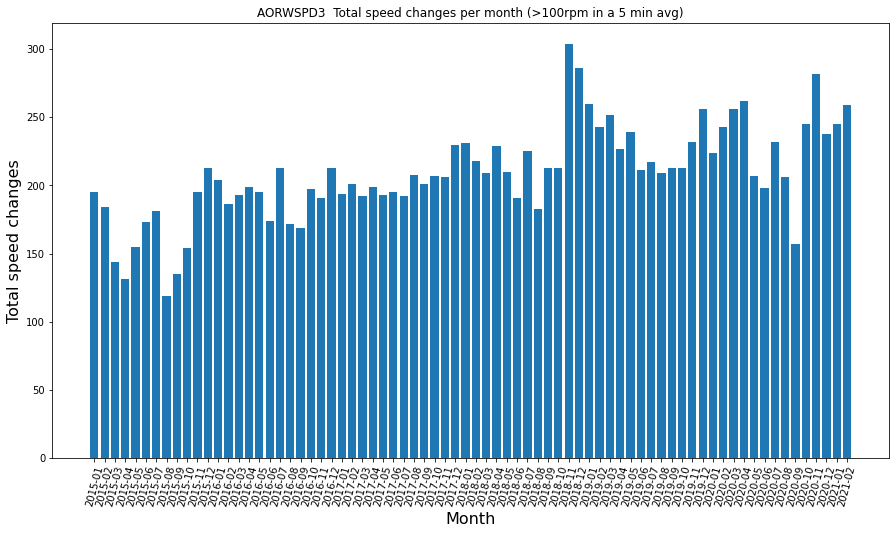

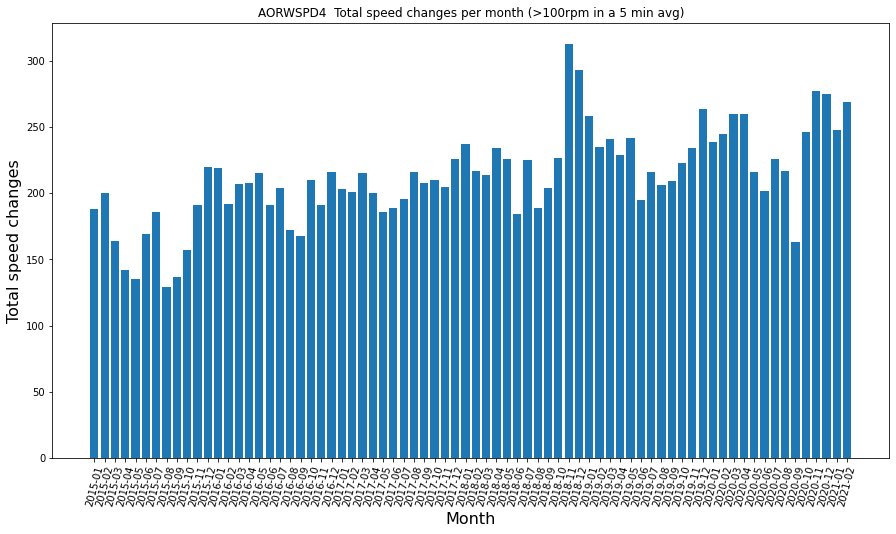

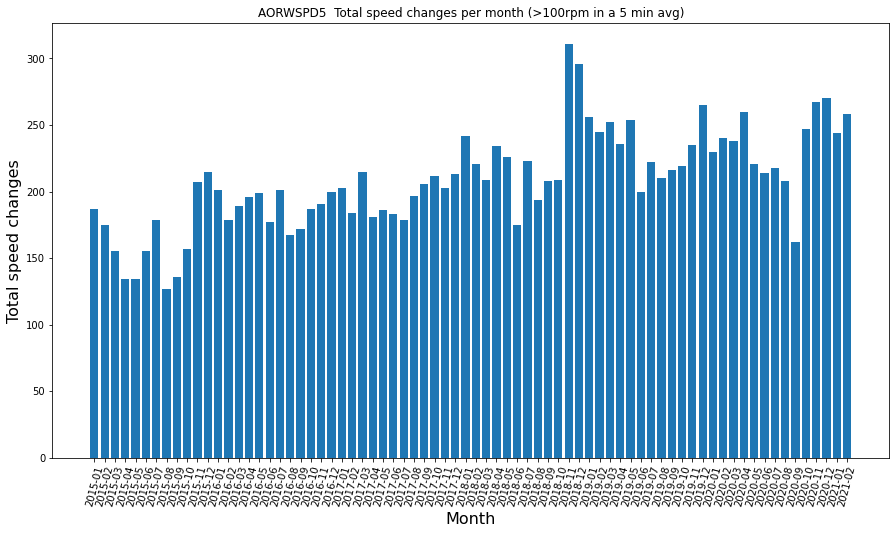

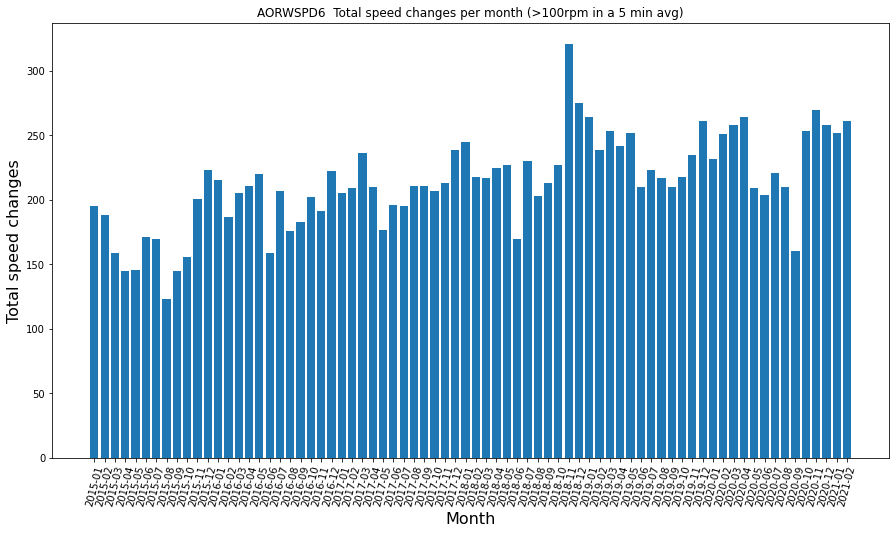

In [9]:
for msid in all_data:
    df = pd.DataFrame()
    df = all_data[msid]
    #number of speed changes, let's define an "abrupt" speed change as more than 100 rpm in 5 minutes
    #smoothed over like a minute and 15 secs
    df['rpm_roll'] = df['rpm'].rolling(20, min_periods = 1).mean()
    df_5min = df[::73].reset_index()
    df_5min['100rpm_change'] = ((df_5min['rpm_roll'].diff().abs())>100).astype(int)

    start_date = pd.Timestamp(df_5min['times'].iloc[0].date())
    end_date = pd.Timestamp(df_5min['times'].iloc[-1].date())
    months = pd.interval_range(start = start_date, end = end_date, freq = 'MS')
    speed_changes = []
    #spd1 = spd1.set_index('times')
    for interval in months:
        m_data = df_5min[(df_5min['times']>= interval.left) & (df_5min['times']<= interval.right)]
        m_spdc = np.array([int(i) for i, k in itertools.groupby(m_data['100rpm_change'])]).sum()
        speed_changes += [m_spdc]
    fig = plt.figure(figsize = (15, 8))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot()
    plt_months = months.left.strftime('%Y-%m')
    ax.bar(plt_months, speed_changes) #index is the time
    ax.set_title("{}  Total speed changes per month (>100rpm in a 5 min avg)".format(msid))
    ax.set_xlabel("Month", fontsize = 16)
    ax.set_ylabel("Total speed changes", fontsize = 16)
    
    ax.tick_params('x', labelrotation = 75)

## Time spent in rpm
We take the wheel speed in rpm and set the number of bins to 50. 
Then we wheigh these bins by the amount of time spent in each rpm which is about 4 seconds per telemetry entry. 

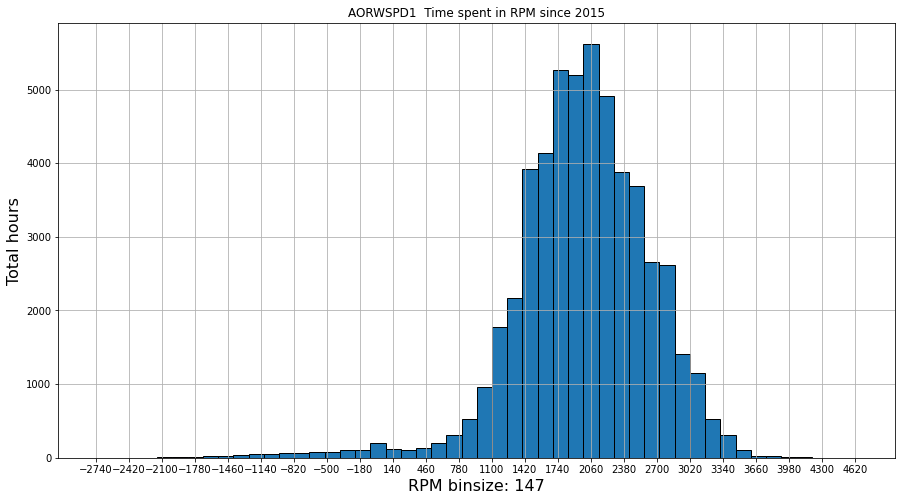

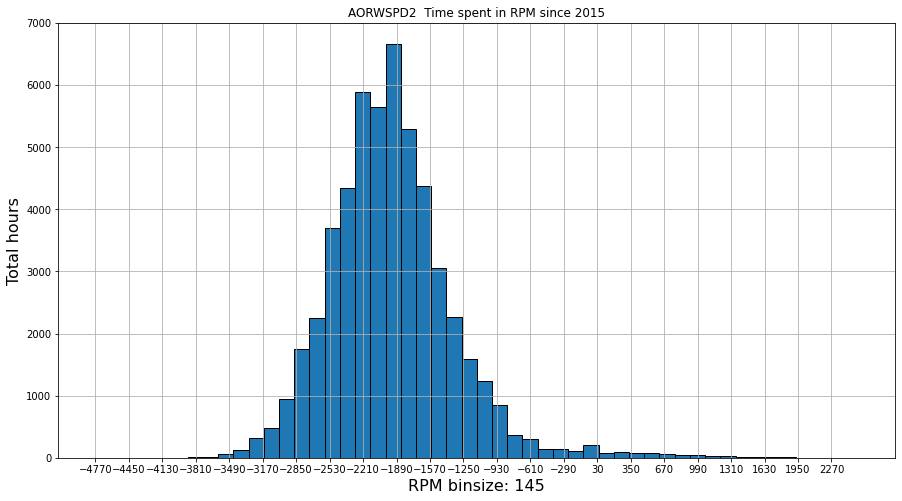

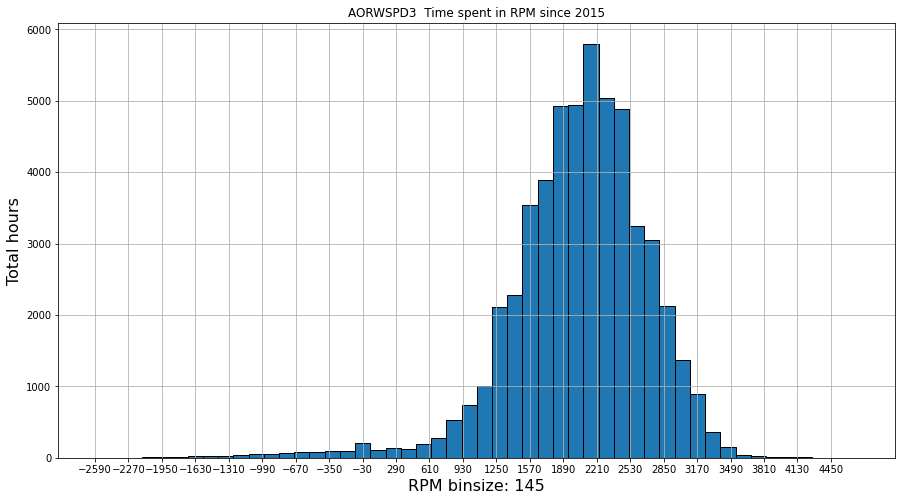

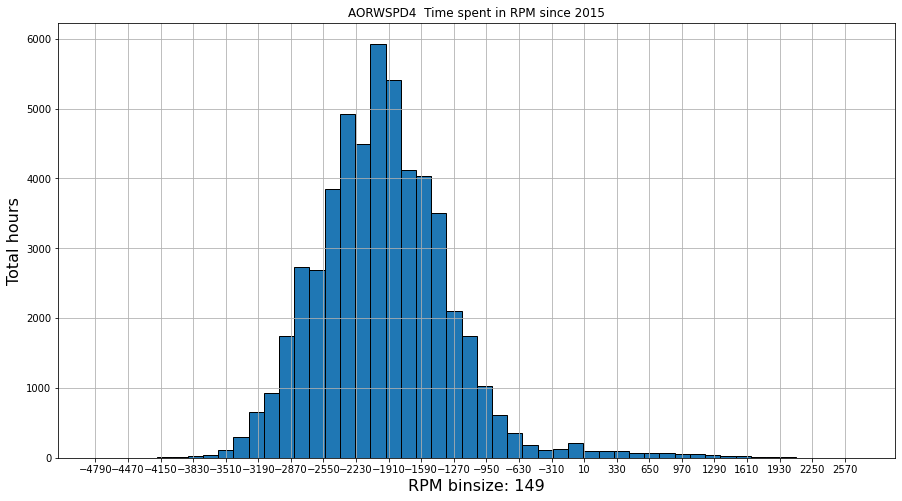

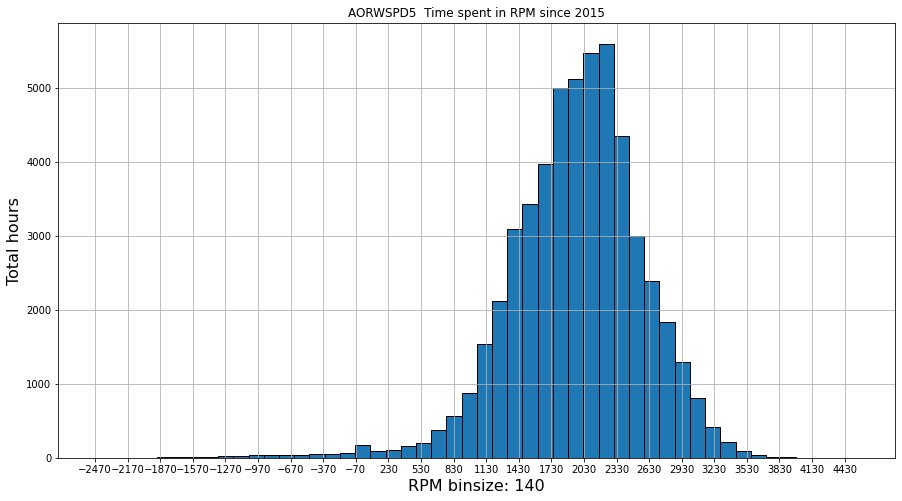

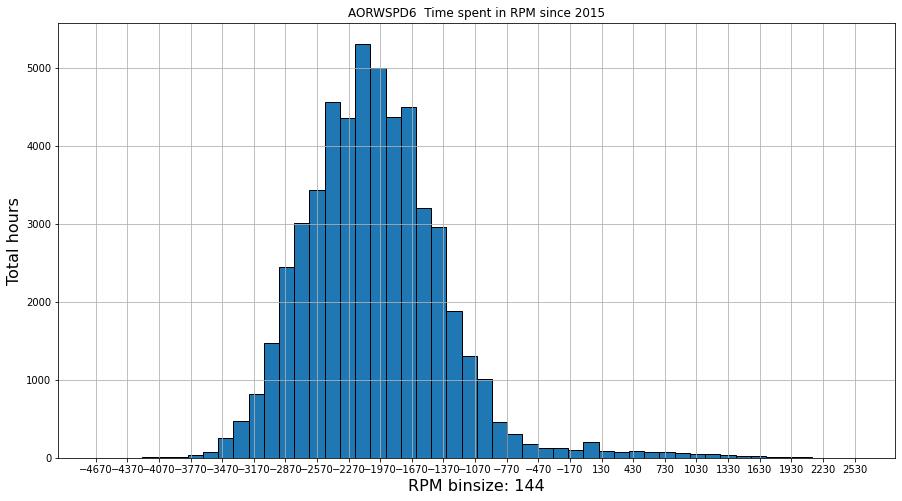

In [10]:
def nearest_mult(base, num, dire):
    return (base * round((num+base*dire)/base))


for msid in all_data:
    df = pd.DataFrame()
    df = all_data[msid]
    #each entry measures 4 seconds so weight each bin by 4 seconds or 1/900 of an hour
    weights = len(df[msid])*[(1/900)]
    fig = plt.figure(figsize = (15, 8))
    ax_hist = fig.add_subplot()
    n, bins, patches = ax_hist.hist(df.rpm, bins = 50, weights = weights, edgecolor = 'black')
    binsize = int(bins[1]-bins[0])
    ax_hist.set_title("{}  Time spent in RPM since 2015".format(msid))
    ax_hist.set_xlabel("RPM binsize: {}".format(binsize), fontsize = 16)
    ax_hist.set_ylabel("Total hours", fontsize = 16)
    ax_hist.grid(True)
    ax_hist.set_xticks(np.arange(nearest_mult(10, bins[0], -1),nearest_mult(10, bins[-1], 1) , nearest_mult(10, binsize, 1)*2))
    plt.show()


## MSID values
Just showing what the available msid values are that are related to reaction wheels. 
CPE values occur only during a safe mode. 

In [11]:
ids = msids.find('REACTION WHEEL')
for i in ids:
    print (i)

AttributeError: 'list' object has no attribute 'find'